# Programming exercise 7: K-means clustering and principal component analysis
Here are my solutions for this exercise. Here are my solutions for this exercise. 
* Jupyter notebook template modified from: https://github.com/dibgerge/ml-coursera-python-assignments.

In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import optimize
from matplotlib import image

## 1 K-means clustering
For this section, I will implement K-means algorithm and use it for image compression. I will be starting on an example 2D dataset that will help me gain an intuition of how the K-means algorithm works. After that, the K-means algorithm will be used for image compression by reducing the number of colors that occur in an image to only those that are most common in that image.

### 1.1 Implementation of K-means

#### 1.1.1 Finding closest centroids
In the “cluster assignment” phase of the K-means algorithm, the algorithm assigns every training example $x^{(i)}$ to its closest centroid, given the current positions of centroids. Specifically, for every example $i$ we set
$$c^{(i)} := j \quad \text{that minimizes} \quad \lvert\rvert x^{(i)} - \mu_j \lvert\rvert^2, $$

where $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$, and $\mu_j$ is the position (value) of the $j^{th}$ centroid. Note that $c^{(i)}$ corresponds to idx[i] in the starter code.

In [181]:
def findClosestCentroids(X, centroids):
    """
    Computes the centroid memberships for every example.
    
    Parameters
    ----------
    X : array_like
        The dataset of size (m, n) where each row is a single example. 
        That is, we have m examples each of n dimensions.
        
    centroids : array_like
        The k-means centroids of size (K, n). K is the number
        of clusters, and n is the the data dimension.
    
    Returns
    -------
    idx : array_like
        A vector of size (m, ) which holds the centroids assignment for each
        example (row) in the dataset X.
    """
    
    # Initialize important parameters
    K = centroids.shape[0]
    m, n = X.shape
    idx = np.zeros(X.shape[0], dtype=int)
    
    for i in range(m):
        distance = np.sum(np.square(centroids - X[i, :]), axis=1)
        idx[i] = np.argmin(distance)
        
    return idx

In [182]:
# Load example dataset
data = sio.loadmat('ex7data2.mat')
X = data['X']

# Select an initial 
K = 3
initial_centroids = np.array(([3, 3], [6, 2], [8, 5]))

# Find the closest centroids for the examples
idx = findClosestCentroids(X, initial_centroids)

print('Closest centroids for the first 3 examples:')
print(idx[:3])
print('(the closest centroids should be 0, 2, 1 respectively)')

Closest centroids for the first 3 examples:
[0 2 1]
(the closest centroids should be 0, 2, 1 respectively)


#### 1.1.2 Computing centroids means
Given assignments of every point to a centroid, the second phase of the algorithm recomputes, for each centroid, the mean of the points that were assigned to it. Specifically, for every centroid $k$ we set
$$ \mu_k := \frac{1}{\left| C_k\right|} \sum_{i \in C_k} x^{(i)}$$

where $C_k$ is the set of examples that are assigned to centroid $k$. 

In [183]:
def computeCentroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the data points
    assigned to each centroid.
    
    Parameters
    ----------
    X : array_like
        The datset where each row is a single data point. That is, it 
        is a matrix of size (m, n) where there are m datapoints each
        having n dimensions. 
    
    idx : array_like 
        A vector (size m) of centroid assignments (i.e. each entry in range [0 ... K-1])
        for each example.
    
    K : int
        Number of clusters
    
    Returns
    -------
    centroids : array_like
        A matrix of size (K, n) where each row is the mean of the data 
        points assigned to it.
    """
    
    # Initialize important variables
    m, n = X.shape
    
    centroids = np.zeros((K, n))
    for i in range(K):
        C_k = len(X[idx == i]) # Number of examples assigned to centroid
        centroids[i] = (1 / C_k) * np.sum(X[idx == i], axis=0)
    
    return centroids

In [184]:
# Compute means based on the closest centroids found
# in the previous section
centroids = computeCentroids(X, idx, K)

print('Centroids computed after initial finding of closest centroids:')
print(centroids)
print('\nThe centroids should be')
print('   [ 2.428301 3.157924 ]')
print('   [ 5.813503 2.633656 ]')
print('   [ 7.119387 3.616684 ]')

Centroids computed after initial finding of closest centroids:
[[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]

The centroids should be
   [ 2.428301 3.157924 ]
   [ 5.813503 2.633656 ]
   [ 7.119387 3.616684 ]


## 1.2 K-means on example dataset
Testing the K-means algorithm.

<IPython.core.display.Javascript object>


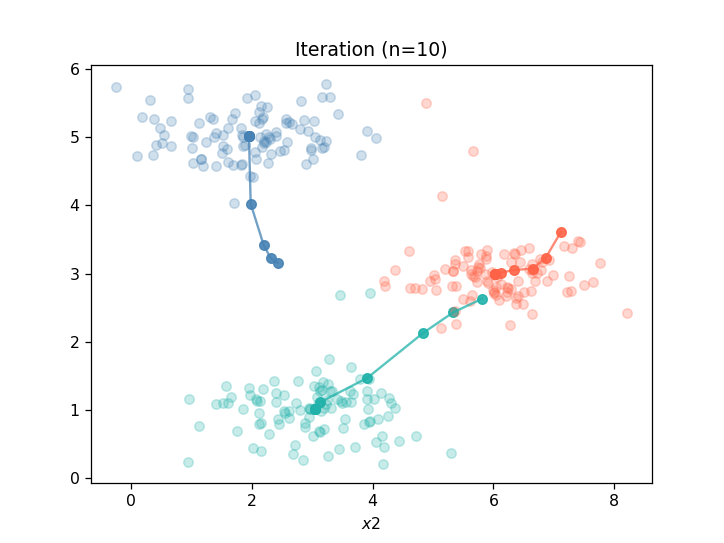

In [187]:
# Load an example dataset
data = sio.loadmat('ex7data2.mat')

# Settings for running K-means
K = 3
max_iters = 10
initial_centroids = np.array(([3, 3], [6, 2], [8, 5]))

# Run K-means algorithm
centroids, idx = runKMeans(X,
                           initial_centroids,
                           findClosestCentroids,
                           computeCentroids,
                           max_iters, plot=True)

In [197]:
def runKMeans(X, initial_centroids, findClosestCentroids, computeCentroids, max_iters, plot):
    """
    Runs the K-means algorithm.
    Parameters
    ----------
    X : array_like
        The data set of size (m, n). Each row of X is a single example of n dimensions. The
        data set is a total of m examples.
    centroids : array_like
        Initial centroid location for each clusters. This is a matrix of size (K, n). K is the total
        number of clusters and n is the dimensions of each data point.
    findClosestCentroids : func
        A function (implemented by student) reference which computes the cluster assignment for
        each example.
    computeCentroids : func
        A function(implemented by student) reference which computes the centroid of each cluster.
    max_iters : int, optional
        Specifies the total number of interactions of K-Means to execute.
    plot_progress : bool, optional
        A flag that indicates if the function should also plot its progress as the learning happens.
        This is set to false by default.
    Returns
    -------
    centroids : array_like
        A (K x n) matrix of the computed (updated) centroids.
    idx : array_like
        A vector of size (m,) for cluster assignment for each example in the dataset. Each entry
        in idx is within the range [0 ... K-1].
    plot : bool
        A matplotlib graph. This is only returned if `plot` is `True`.
    """
    
    # Initialize important variables
    m, n = X.shape
    centroids = initial_centroids
    plot_centroids = np.zeros((max_iters, K, n))
    
    for i in range(max_iters):
        idx = findClosestCentroids(X, centroids)
        centroids = computeCentroids(X, idx, K)
        if plot == True: plot_centroids[i] = centroids
    
    if plot == True:
        fig = plt.figure()
        color = ['steelblue', 'lightseagreen', 'tomato']

        for i in range(K):
            plt.scatter(plot_centroids.T[0][i],
                        plot_centroids.T[1][i], 
                        color=color[i], alpha=0.90)

            plt.plot(plot_centroids.T[0][i],
                     plot_centroids.T[1][i],
                     color=color[i], alpha=0.75)

            plt.scatter(X[idx == i].T[0],
                        X[idx == i].T[1],
                        color=color[i], alpha=0.25)

        plt.xlabel(r'$x1$')
        plt.xlabel(r'$x2$')
        plt.title('Iteration (n=10)')

        plt.show()
        
    return centroids, idx

## 1.3 Random initialization
The initial assignments of centroids for the example dataset in the previous cell were designed so that you will see the same figure as that shown in the cell above. In practice, a good strategy for initializing the centroids is to select random examples from the training set.

In [189]:
def kMeansInitCentroids(X, K):
    """
    This function initializes K centroids that are to be 
    used in K-means on the dataset x.
    
    Parameters
    ----------
    X : array_like 
        The dataset of size (m x n).
    
    K : int
        The number of clusters.
    
    Returns
    -------
    centroids : array_like
        Centroids of the clusters. 
        This is a matrix of size (K x n).
    """
    
    # Initialize important parameters
    m, n = X.shape
    centroids = np.zeros((K, n))
    
    random_idx = np.random.permutation(m)
    centroids = X[random_idx[:K], :]
    
    return centroids

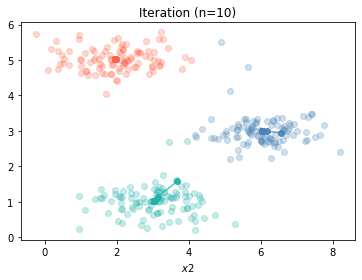

In [10]:
# Load an example dataset
data = sio.loadmat('ex7data2.mat')

# Settings for running K-means
K = 3
max_iters = 10
initial_centroids = kMeansInitCentroids(X, K)

# Run K-means algorithm
centroids, idx = runKMeans(X,
                           initial_centroids,
                           findClosestCentroids,
                           computeCentroids,
                           max_iters, plot=True)

## 1.4 Image compression with K-means
In this exercise, I will apply K-means to image compression. I will use the image below as an example.

In [19]:
# Load 128x128 color image with matplotlib
img = image.imread('bird_small.png')
print(f'Image details: \t{img.shape}')

Image details: 	(128, 128, 3)


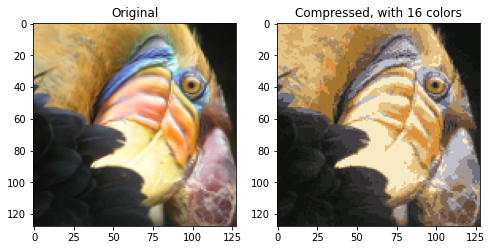

In [18]:
# Image compression with K-means
# Initialize parameters
K = 16
max_iters = 10

# Divide by 255 so all values are between 0 - 1
img /= 255

# Reshape image into a Nx3 matrix where N = number of pixels
X = img.reshape(-1, 3)

# Randomly initialize centroids
initial_centroids = kMeansInitCentroids(X, K)

# Run K-means
centroids, idx = runKMeans(X, initial_centroids,
                           findClosestCentroids, computeCentroids,
                           max_iters, False)

# Recover the image from indices by mapping each pixel to
# centroid value
X_recovered = centroids[idx, :].reshape(img.shape)

# Display the original image, rescale back by 255
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img * 255)
ax[0].set_title('Original')
ax[0].grid(False)

# Display compressed image, rescale back by 255
ax[1].imshow(X_recovered * 255)
ax[1].set_title('Compressed, with %d colors' % K)
ax[1].grid(False)

## 2 Principal component analysis
I will use principal component analysis (PCA) to perform dimensionality reduction. I will first experiment with an example 2D dataset to get intuition on how PCA works, and then use it on a bigger dataset of 5000 face image dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import optimize
from matplotlib import image

### 2.1 Example dataset

In [4]:
# Load example dataset
data = sio.loadmat('ex7data1.mat')
X = data['X']
print ('Details of dataset')
print ('Data\t\tShape')
print (f'X\t\t{X.shape}')

Details of dataset
Data		Shape
X		(50, 2)


Text(0, 0.5, '$x2$')

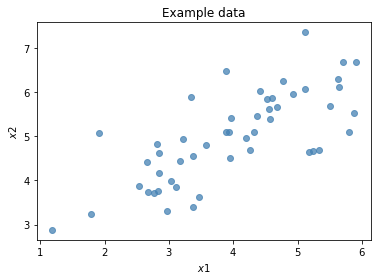

In [14]:
# Visualize example dataset
plt.scatter(X[:, 0], X[:, 1], color='steelblue', alpha=0.75)
plt.title('Example data')
plt.xlabel(r'$x1$')
plt.ylabel(r'$x2$')

### 2.2 Implementing PCA
In this part of the exercise, er will implement PCA. PCA consists of two computational steps:

* Compute the covariance matrix of the data.
* Use SVD (in python we use numpy's implementation np.linalg.svd) to compute the eigenvectors $U_1$, $U_2$, $\dots$, $U_n$. These will correspond to the principal components of variation in the data.

First, compute the covariance matrix of the data, which is given by:
$$ \Sigma = \frac{1}{m} X^T X$$

where $X$ is the data matrix with examples in rows, and $m$ is the number of examples. Note that $\Sigma$ is a $n \times n$ matrix and not the summation operator.

After computing the covariance matrix, run SVD on it to compute the principal components. In python and numpy (or scipy), you can run SVD with the following command: `U, S, V = np.linalg.svd(Sigma)`, where U will contain the principal components and S will contain a diagonal matrix. 

*Note that the scipy library also has a similar function to compute SVD scipy.linalg.svd. The functions in the two libraries use the same C-based library (LAPACK) for the SVD computation, but the scipy version provides more options and arguments to control SVD computation. In this exercise, we will stick with the numpy implementation of SVD.*

In [91]:
def pca(X):
    """
    Run principal component analysis.
    
    Parameters
    ----------
    X : array_like
        The dataset to be used for computing PCA. It has dimensions (m x n)
        where m is the number of examples (observations) and n is 
        the number of features.
    
    Returns
    -------
    U : array_like
        The eigenvectors, representing the computed principal components
        of X. U has dimensions (n x n) where each column is a single 
        principal component.
    
    S : array_like
        A vector of size n, contaning the singular values for each
        principal component.
    """
    
    # Initialize important parameters
    m, n = X.shape
    
    # Compute covariance matrix of the data
    SIGMA = (1 / m) * X.T.dot(X)
    
    # Run SVD to compute principal components
    U, S, V = np.linalg.svd(SIGMA)
    
    return U, S

In [92]:
def featureNormalize(X):
    """
    Normalizes the features in X returns a normalized version of X where the mean value of each
    feature is 0 and the standard deviation is 1. This is often a good preprocessing step to do when
    working with learning algorithms.
    Parameters
    ----------
    X : array_like
        An dataset which is a (m x n) matrix, where m is the number of examples,
        and n is the number of dimensions for each example.
    Returns
    -------
    X_norm : array_like
        The normalized input dataset.
    mu : array_like
        A vector of size n corresponding to the mean for each dimension across all examples.
    sigma : array_like
        A vector of size n corresponding to the standard deviations for each dimension across
        all examples.
    """
    
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1)
    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma

In [93]:
# Normalize features
X_norm, mu, sigma = featureNormalize(X)

# Run PCA
U, S = pca(X_norm)

Top eigenvector: U[:, 0] = [(-0.7071067811865475, -0.7071067811865477)]


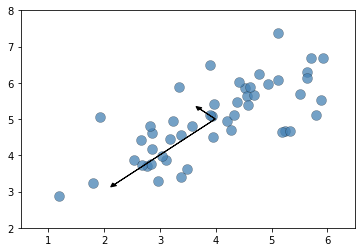

In [94]:
# Draw eigenvectors centered at the mean of data
# The lines show the maximum variations in the dataset
fig, ax = plt.subplots()
ax.plot(X[:, 0], X[:, 1], 'bo', ms=10, mec='k', mew=0.25, color='steelblue', alpha=0.75)

for i in range(2):
    ax.arrow(mu[0], mu[1],
             1.5 * S[i] * U[0, i],
             1.5 * S[i] * U[1, i],
             head_width=0.1, head_length=0.1,
             fc='k', ec='k', lw=1, zorder=1000)
    
ax.axis([0.5, 6.5, 2, 8])

print(f'Top eigenvector: U[:, 0] = [{U[0,0], U[1,0]}]')

### 2.3 Dimensionality reduction with PCA
After computing the principal components, we can use them to reduce the feature dimension of your dataset by projecting each example onto a lower dimensional space, $x^{(i)} \rightarrow z^{(i)}$ (e.g., projecting the data from 2D to 1D). In this part of the exercise, we will use the eigenvectors returned by PCA and project the example dataset into a 1-dimensional space.

#### 2.3.1 Projecting data onto the principal components

Text(0, 0.5, '$x2$')

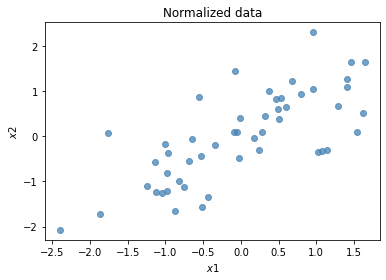

In [114]:
# Plot normalized dataset (returned from pca)
plt.scatter(X_norm[:, 0], X_norm[:, 1], color='steelblue', alpha=0.75)
plt.title('Normalized data')
plt.xlabel(r'$x1$')
plt.ylabel(r'$x2$')

In [111]:
def projectData(X, U, K):
    """
    Computes the reduced data representation when projecting only 
    on to the top K eigenvectors.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n). The dataset is assumed to be 
        normalized.
    
    U : array_like
        The computed eigenvectors using PCA. This is a matrix of 
        shape (n x n). Each column in the matrix represents a single
        eigenvector (or a single principal component).
    
    K : int
        Number of dimensions to project onto. Must be smaller than n.
    
    Returns
    -------
    Z : array_like
        The projects of the dataset onto the top K eigenvectors. 
        This will be a matrix of shape (m x k).
    """
    
    U_reduce = U[:, :K]
    Z = X.dot(U_reduce)
    
    return Z

In [112]:
# Project the data onto K = 1 dimension
K = 1
Z = projectData(X_norm, U, K)
print(f'Projection of the first example: {Z[0]}')
print('(this value should be about    : 1.481274)')

Projection of the first example: [1.48127391]
(this value should be about    : 1.481274)


#### 2.3.2 Reconstruction an approximation of the data

In [126]:
def recoverData(Z, U, K):
    """
    Recovers an approximation of the original data when using the 
    projected data.
    
    Parameters
    ----------
    Z : array_like
        The reduced data after applying PCA. This is a matrix
        of shape (m x K).
    
    U : array_like
        The eigenvectors (principal components) computed by PCA.
        This is a matrix of shape (n x n) where each column represents
        a single eigenvector.
    
    K : int
        The number of principal components retained
        (should be less than n).
    
    Returns
    -------
    X_rec : array_like
        The recovered data after transformation back to the original 
        dataset space. This is a matrix of shape (m x n), where m is 
        the number of examples and n is the dimensions (number of
        features) of original datatset.
        
    """
    
    U_reduce = U[:, :K]
    X_rec = Z.dot(U_reduce.T)
    print(U_reduce.shape, Z.shape, X_rec.shape)
    
    return X_rec

(2, 1) (50, 1) (50, 2)
Approximation of the first example: (-1.0474188259204964, -1.0474188259204966)
       (this value should be about  [-1.047419 -1.047419])


Text(0, 0.5, '$x2$')

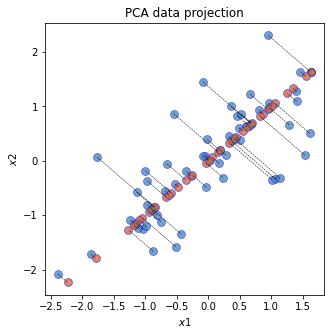

In [145]:
# Recover data 
X_rec = recoverData(Z, U, K)
print(f'Approximation of the first example: {X_rec[0, 0], X_rec[0, 1]}')
print('       (this value should be about  [-1.047419 -1.047419])')


# Plot the normalized dataset
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(X_norm[:, 0], X_norm[:, 1],
        'o', color='steelblue',
        alpha=0.75, ms=8, mec='b', mew=0.5)
ax.plot(X_rec[:, 0], X_rec[:, 1],
        'o', color='tomato',
        alpha=0.75, ms=8, mec='b', mew=0.5)

# Draw lines connecing the projected points to the original
ax.plot(X_rec[:, 0], X_rec[:, 0],
        'o', color='tomato', alpha=0.2,
        mec='teal', mew=2, mfc=None)
for xnorm, xrec in zip(X_norm, X_rec):
    ax.plot([xnorm[0], xrec[0]], [xnorm[1], xrec[1]], '--k', lw=0.5)
    
plt.title('PCA data projection')
plt.xlabel(r'$x1$')
plt.ylabel(r'$x2$')

### 2.4 Face image dataset
The dataset `ex7faces.mat` contains a dataset X of face images, each $32 \times 32$ in grayscale. This dataset was based on a cropped version of the labeled faces in the wild dataset. Each row of X corresponds to one face image (a row vector of length 1024).

The next cell will load and visualize the first 100 of these face images.

Details of dataset
Data		Shape
X		(5000, 1024)


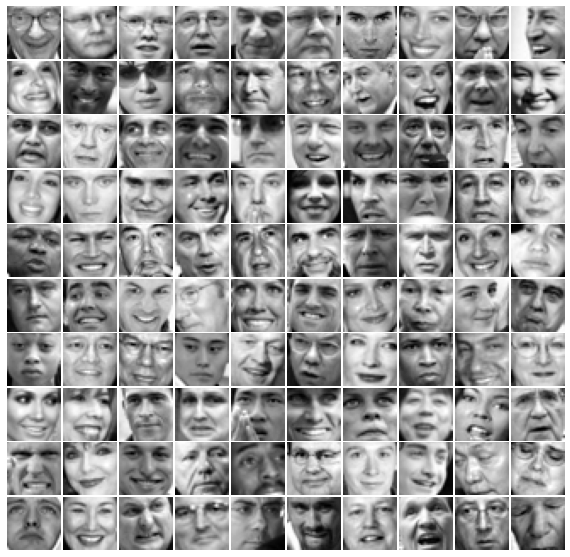

In [172]:
# Load face dataset
data = sio.loadmat('ex7faces.mat')
X = data['X']
print ('Details of dataset')
print ('Data\t\tShape')
print (f'X\t\t{X.shape}')

displayData(X[:100, :])

In [170]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data in a nice grid.
    Parameters
    ----------
    X : array_like
        The input data of size (m x n) where m is the number of examples and n is the number of
        features.
    example_width : int, optional
        THe width of each 2-D image in pixels. If not provided, the image is assumed to be square,
        and the width is the floor of the square root of total number of pixels.
    figsize : tuple, optional
        A 2-element tuple indicating the width and height of figure in inches.
    """
    
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None] # Promote to 2D array
    else:
        raise IndexError('Input should be 1D or 2D')
    
    example_width = example_width or int(np.round(np.sqrt(n))) #20x20 pixels
    example_height = int(n / example_width)
    
    # Compute number of images to display
    display_row = int(np.floor(np.sqrt(m)))
    display_col = int(np.ceil(m / display_row))
    
    fig, ax_array = plt.subplots(display_row, display_col, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)
    
    ax_array = [ax_array] if m == 1 else ax_array.ravel()
    
    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='gray',
                  extent=[0, 1, 0, 1])
        ax.axis('off')

#### 2.4.1 PCA on faces

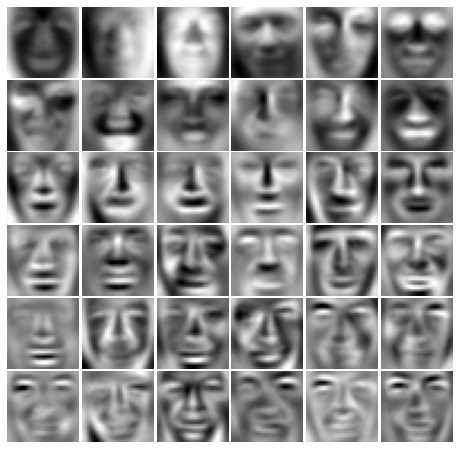

In [174]:
# Normalize X by subtracting mean value from each feature
X_norm, mu, sigma = featureNormalize(X)

# Run PCA
U, S = pca(X_norm)

# Visualize the top 36 eigenvectors found
displayData(U[:, :36].T, figsize=(8, 8))

#### 2.4.2 Dimentionality reduction

In [175]:
# Project images to the eigen space using the top k eigenvectors
K = 100
Z = projectData(X_norm, U, K)

print('The projected data Z has a shape of: ', Z.shape)

The projected data Z has a shape of:  (5000, 100)


(1024, 100) (5000, 100) (5000, 1024)


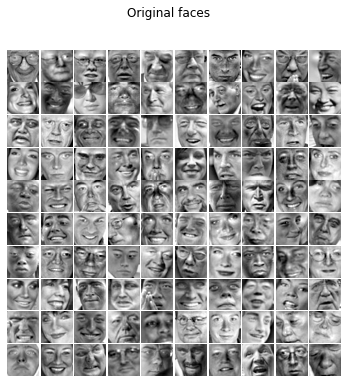

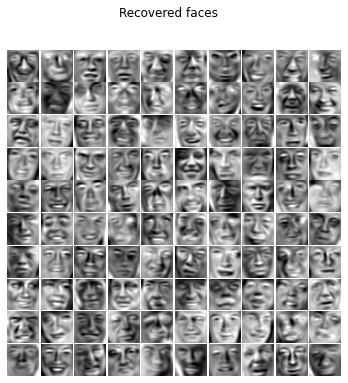

In [176]:
#  Project images to the eigen space using the top K eigen vectors and 
#  visualize only using those K dimensions
#  Compare to the original input, which is also displayed
K = 100
X_rec  = recoverData(Z, U, K)

# Display normalized data
displayData(X_norm[:100, :], figsize=(6, 6))
plt.gcf().suptitle('Original faces')

# Display reconstructed data from only k eigenfaces
displayData(X_rec[:100, :], figsize=(6, 6))
plt.gcf().suptitle('Recovered faces')
pass

### PCA for visualization

<IPython.core.display.Javascript object>


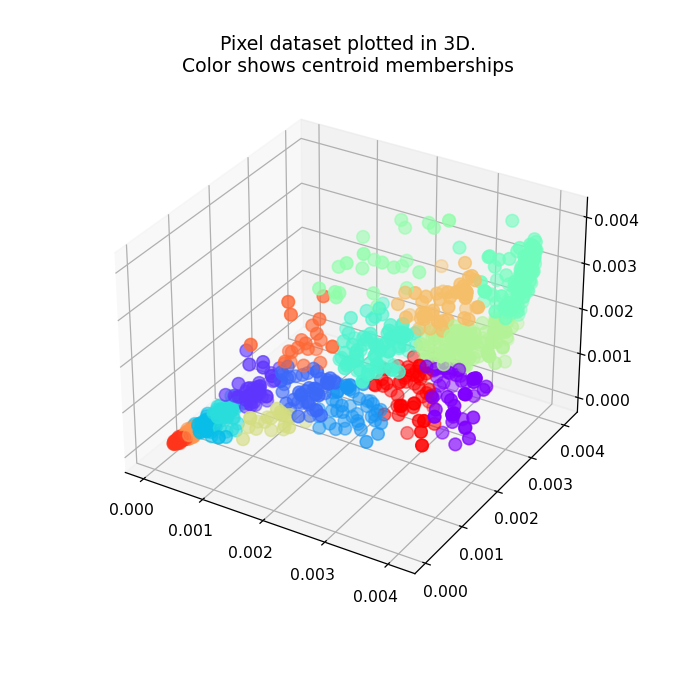

In [195]:
# this allows to have interactive plot to rotate the 3-D plot
# The double identical statement is on purpose
# see: https://stackoverflow.com/questions/43545050/using-matplotlib-notebook-after-matplotlib-inline-in-jupyter-notebook-doesnt
%matplotlib notebook
%matplotlib notebook
from matplotlib import pyplot


A = image.imread('bird_small.png')
A /= 255
X = A.reshape(-1, 3)

# perform the K-means clustering again here
K = 16
max_iters = 10
initial_centroids = kMeansInitCentroids(X, K)
centroids, idx = runKMeans(X, initial_centroids,
                           findClosestCentroids,
                           computeCentroids, max_iters, False)

#  Sample 1000 random indexes (since working with all the data is
#  too expensive. If you have a fast computer, you may increase this.
sel = np.random.choice(X.shape[0], size=1000)

fig = pyplot.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[sel, 0], X[sel, 1], X[sel, 2], cmap='rainbow', c=idx[sel], s=8**2)
ax.set_title('Pixel dataset plotted in 3D.\nColor shows centroid memberships')
pass

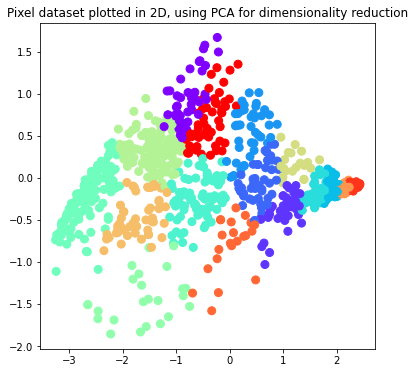

In [196]:
# Subtract the mean to use PCA
X_norm, mu, sigma = featureNormalize(X)

# PCA and project the data to 2D
U, S = pca(X_norm)
Z = projectData(X_norm, U, 2)

# Reset matplotlib to non-interactive
%matplotlib inline

fig = pyplot.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.scatter(Z[sel, 0], Z[sel, 1], cmap='rainbow', c=idx[sel], s=64)
ax.set_title('Pixel dataset plotted in 2D, using PCA for dimensionality reduction')
ax.grid(False)
pass